In [1]:
from fastai import *
from fastai.vision import *
from fastai.vision.models.unet import DynamicUnet
from fastai.vision.learner import cnn_config
from fastai.callbacks import *
import sys
sys.path.append('../../')
sys.path.append('../../model')
from model.losses import *
from model.bpho.resnet import *
from model.bpho.unet import *
from model.metrics import psnr, ssim
from data.load_fluo import *

In [2]:
import matplotlib.pyplot as plt

In [3]:
gpu_id = 0
num_cores = 4
torch.cuda.set_device(gpu_id)

### data load

In [4]:
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/training/trainsets/')

In [5]:
bs=4
lr = slice(None, 4e-4, None)
size=512 
tile_sz=512 
# datasetname=multi_100mitotracker 
cycles=100
# save_name=multit_5_100mito_opt_001 
n_frames=5

In [6]:
lr_type = 't'
if lr_type == 's':
    z_frames, t_frames = 1, 1
    n_frames = 1
    dataset = data_pth/'mitotracker_PSSR-SF'
    hr_tifs = dataset/f'hr'
    lr_tifs = dataset/f'lr'
elif lr_type == 't':
    z_frames, t_frames = 1, 5
    n_frames = 5
    multi_str = f'_{lr_type}_{n_frames}'
    tile_sz = 512
    dataset = data_pth/'mitotracker_PSSR-MF'
    hr_tifs = dataset/f'hr_t_{tile_sz:d}{multi_str}'
    lr_tifs = dataset/f'lr_t_{tile_sz:d}{multi_str}'

In [7]:
mode = 'L'
norm = True
noise = False
cutout = False # Maybe?

In [8]:
data = get_data(bs, size, lr_tifs, hr_tifs, n_frames=n_frames,  max_zoom=4., 
                    use_cutout=cutout, use_noise=noise, mode=mode, norm=norm)

normalizing x and y data


/home/rusl/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/home/rusl/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/home/rusl/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/home/rusl/anaconda3/lib/python3.7/site-packages/

### initiate learner

In [9]:
wnres_args = {
    'blur': True,
    'blur_final': True,
    'bottle': True,
    'self_attention': True,
    'last_cross': True
}

In [10]:
arch = 'wnresnet34'
wd = 1e-3
arch = eval(arch)
metrics = [psnr, ssim]

# Lj & ours

In [11]:
model_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/models')
state_dict = torch.load(model_pth/'feat_loss'/'sf_state_dict.pkl')

In [23]:
model_name = 'mitotracker_PSSR-MF_512'
learn_lj = load_learner(path=model_pth/'baselines', file=f'{model_name}.pkl')
learn_lj.model.load_state_dict(state_dict)

<All keys matched successfully>

In [24]:
learn = wnres_unet_learner(data, arch, in_c=n_frames, wnres_args=wnres_args,
                         metrics=metrics, model_dir=model_pth, callback_fns=[LossMetrics], wd=wd)
learn.model.load_state_dict(state_dict)

<All keys matched successfully>

In [14]:
xb, yb = learn.data.one_batch()

/home/rusl/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/home/rusl/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/home/rusl/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/home/rusl/anaconda3/lib/python3.7/site-packages/

## Make sure batch norm stats are the same

In [24]:
learn.data.tfms, learn_lj.data.tfms

([functools.partial(<function _multi_normalize_batch at 0x7f2e110c6830>, mean=tensor(0.0893), std=tensor(0.1058), do_x=True, do_y=True)],
 [functools.partial(<function _multi_normalize_batch at 0x7f2e110c6830>, mean=tensor(0.0893), std=tensor(0.1058), do_x=True, do_y=True)])

In [25]:
learn.data.remove_tfm(learn.data.tfms[0])
learn.data.add_tfm(learn_lj.data.tfms[0])

In [18]:
x = learn.data.train_ds[0][0]

/home/rusl/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


In [27]:
torch.allclose(learn.data.one_item(x)[0], learn_lj.data.one_item(x)[0])

True

## Make sure loss functions are the same
Otherwise pred_batch breaks: https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L350

In [25]:
type(learn.loss_func), type(learn_lj.loss_func)

(function, model.losses.FeatureLoss)

In [26]:
learn.loss_func

<function torch.nn.functional.nll_loss(input, target, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')>

In [27]:
learn_lj.loss_func

FeatureLoss(
  (m_feat): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [16]:
learn.loss_func = learn_lj.loss_func

## Predict

In [19]:
one_item = learn.data.one_item(x)
one_item2 = learn_lj.data.one_item(x)

In [20]:
learn.pred_batch(ds_type=0, batch=one_item)

tensor([[[[-0.8466, -0.8425, -0.8506,  ..., -0.8547, -0.8610, -0.8626],
          [-0.8436, -0.8497, -0.8593,  ..., -0.8545, -0.8540, -0.8552],
          [-0.8455, -0.8530, -0.8565,  ..., -0.8559, -0.8557, -0.8474],
          ...,
          [-0.8317, -0.8347, -0.8297,  ..., -0.7038, -0.7050, -0.7193],
          [-0.8338, -0.8194, -0.8396,  ..., -0.6993, -0.7118, -0.7284],
          [-0.8330, -0.8230, -0.8432,  ..., -0.6839, -0.7100, -0.7064]]]])

In [21]:
learn_lj.pred_batch(ds_type=0, batch=one_item)

tensor([[[[-0.8466, -0.8425, -0.8506,  ..., -0.8547, -0.8610, -0.8626],
          [-0.8436, -0.8497, -0.8593,  ..., -0.8545, -0.8540, -0.8552],
          [-0.8455, -0.8530, -0.8565,  ..., -0.8559, -0.8557, -0.8474],
          ...,
          [-0.8317, -0.8347, -0.8297,  ..., -0.7038, -0.7050, -0.7193],
          [-0.8338, -0.8194, -0.8396,  ..., -0.6993, -0.7118, -0.7284],
          [-0.8330, -0.8230, -0.8432,  ..., -0.6839, -0.7100, -0.7064]]]])

In [ ]:
learn.model.eval()
learn.predict(x)

In [ ]:
learn_lj.model.eval()
learn_lj.predict(x)

In [ ]:
learn.model.eval()
learn_lj.model.eval()
with torch.no_grad():
    out = learn.model(xb.cuda())
    out_lj = learn_lj.model(xb.cuda())

In [ ]:
torch.allclose(out, out_lj)

In [29]:
# learn.data.single_ds.y.reconstruct(t=yb[0]).data[0]

# learn_lj.data.single_ds.y.reconstruct(t=yb[0]).data[0]

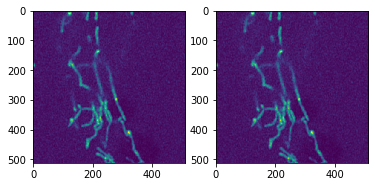

In [30]:
plt.subplot(1, 2, 1)
plt.imshow(learn.data.single_ds.y.reconstruct(t=yb[0]).data[0])
plt.subplot(1, 2, 2)
plt.imshow(learn_lj.data.single_ds.y.reconstruct(t=yb[0]).data[0])
plt.show()

In [ ]:
learn_lj.data.single_ds??